# Propensity Scores Estimation

In [1]:
!pip install umap-learn

In [2]:
import csv
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter

simplefilter(action='ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\omerm\miniconda3\envs\CausalInferenceProject\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
domains = ['music', 'politics', 'health', 'technology']
X_text_dict = dict()
X_user_description_dict = dict()
X_user_covariates_dict = dict()
T_dict = dict()
Y_dict = dict()

for domain in domains:
    with open(f'pickles/encodings/{domain}/X_text_reduced.pkl', 'rb') as f: X_text_dict[domain] = pickle.load(f)
    with open(f'pickles/encodings/{domain}/X_user_description_reduced.pkl', 'rb') as f: X_user_description_dict[domain] = pickle.load(f)
    with open(f'pickles/encodings/{domain}/X_user_covariates.pkl', 'rb') as f: X_user_covariates_dict[domain] = pickle.load(f)
    with open(f'pickles/encodings/{domain}/T.pkl', 'rb') as f: T_dict[domain] = pickle.load(f)
    with open(f'pickles/encodings/{domain}/Y.pkl', 'rb') as f: Y_dict[domain] = pickle.load(f)

In [4]:
def est_propensity_within_domain(X_text_dict, X_user_description_dict, X_user_covariates_dict, T_dict, Y_dict, t1, t2, domain):
    # take relevant domain data
    X_text = X_text_dict[domain]
    X_user_description = X_user_description_dict[domain]
    X_user_covariates = X_user_covariates_dict[domain]
    T = T_dict[domain]
    Y = Y_dict[domain]
    
    # take rows of t1, t2
    idx = ((T == t1) | (T == t2)).nonzero()
    X_text = X_text[idx]
    X_user_description = X_user_description[idx]
    X_user_covariates = X_user_covariates[idx]
    T = T[idx]
    Y = Y[idx]
    
    # transform t1 -> 0, t2 -> 1
    T = np.array([0 if t == t1 else 1 for t in T])
    
    # transform (concat & scale) covariates
    scaler = StandardScaler()
    X_scaled_user_covariates = scaler.fit_transform(X_user_covariates)
    X = np.hstack([X_text, X_user_description, X_scaled_user_covariates])
    
    # define and train model
    model = LogisticRegression(max_iter=1000, penalty='none', class_weight='balanced')
    model.fit(X, T)
    
    # predict
    propensities = np.array([p[1] for p in model.predict_proba(X)])
    
    # evaluate
    pred = model.predict(X)
    fpr, tpr, thresholds = roc_curve(T, pred)
    
    return propensities, auc(fpr, tpr)

In [5]:
def plot_propensity(ax, T_dict, t1, t2, domain, propensities, title):
    treatment_mapper = ['0-6', '6-12', '12-18', '18-24']
    propensity_score = propensities[domain][(t1,t2)][0]
    T = T_dict[domain]
    T = T[(T == t1) | (T == t2)]
    t1_idx = (T == t1).nonzero()
    t2_idx = (T == t2).nonzero()
    t1_plt = ax.hist(propensity_score[t1_idx], fc=(0, 0, 1, 0.5), bins=20, label=f'{treatment_mapper[t1]}', density=True)
    t2_plt = ax.hist(propensity_score[t2_idx], fc=(1, 0, 0, 0.5), bins=20, label=f'{treatment_mapper[t2]}', density=True)
    ax.legend();
    ax.set_xlabel('propensity score');
    ax.set_ylabel('density');
    ax.set_title(title);

In [6]:
propensities = {
    'music': dict(),
    'politics': dict(),
    'health': dict(),
    'technology': dict()
}

treatment_pairs = [(0,1), (1,2), (2,3), (3,0)]

for domain in domains:
    for (t1, t2) in treatment_pairs:
        propensities[domain][(t1,t2)] = est_propensity_within_domain(X_text_dict, 
                                                                     X_user_description_dict, 
                                                                     X_user_covariates_dict, 
                                                                     T_dict, Y_dict, 
                                                                     t1=t1, t2=t2, domain=domain)
        print(f'AUC({domain},{(t1,t2)})={round(propensities[domain][(t1,t2)][1], 3)}')

AUC(music,(0, 1))=0.754
AUC(music,(1, 2))=0.74
AUC(music,(2, 3))=0.653
AUC(music,(3, 0))=0.692
AUC(politics,(0, 1))=0.827
AUC(politics,(1, 2))=0.803
AUC(politics,(2, 3))=0.724
AUC(politics,(3, 0))=0.743
AUC(health,(0, 1))=0.752
AUC(health,(1, 2))=0.758
AUC(health,(2, 3))=0.655
AUC(health,(3, 0))=0.731
AUC(technology,(0, 1))=0.786
AUC(technology,(1, 2))=0.79
AUC(technology,(2, 3))=0.67
AUC(technology,(3, 0))=0.781


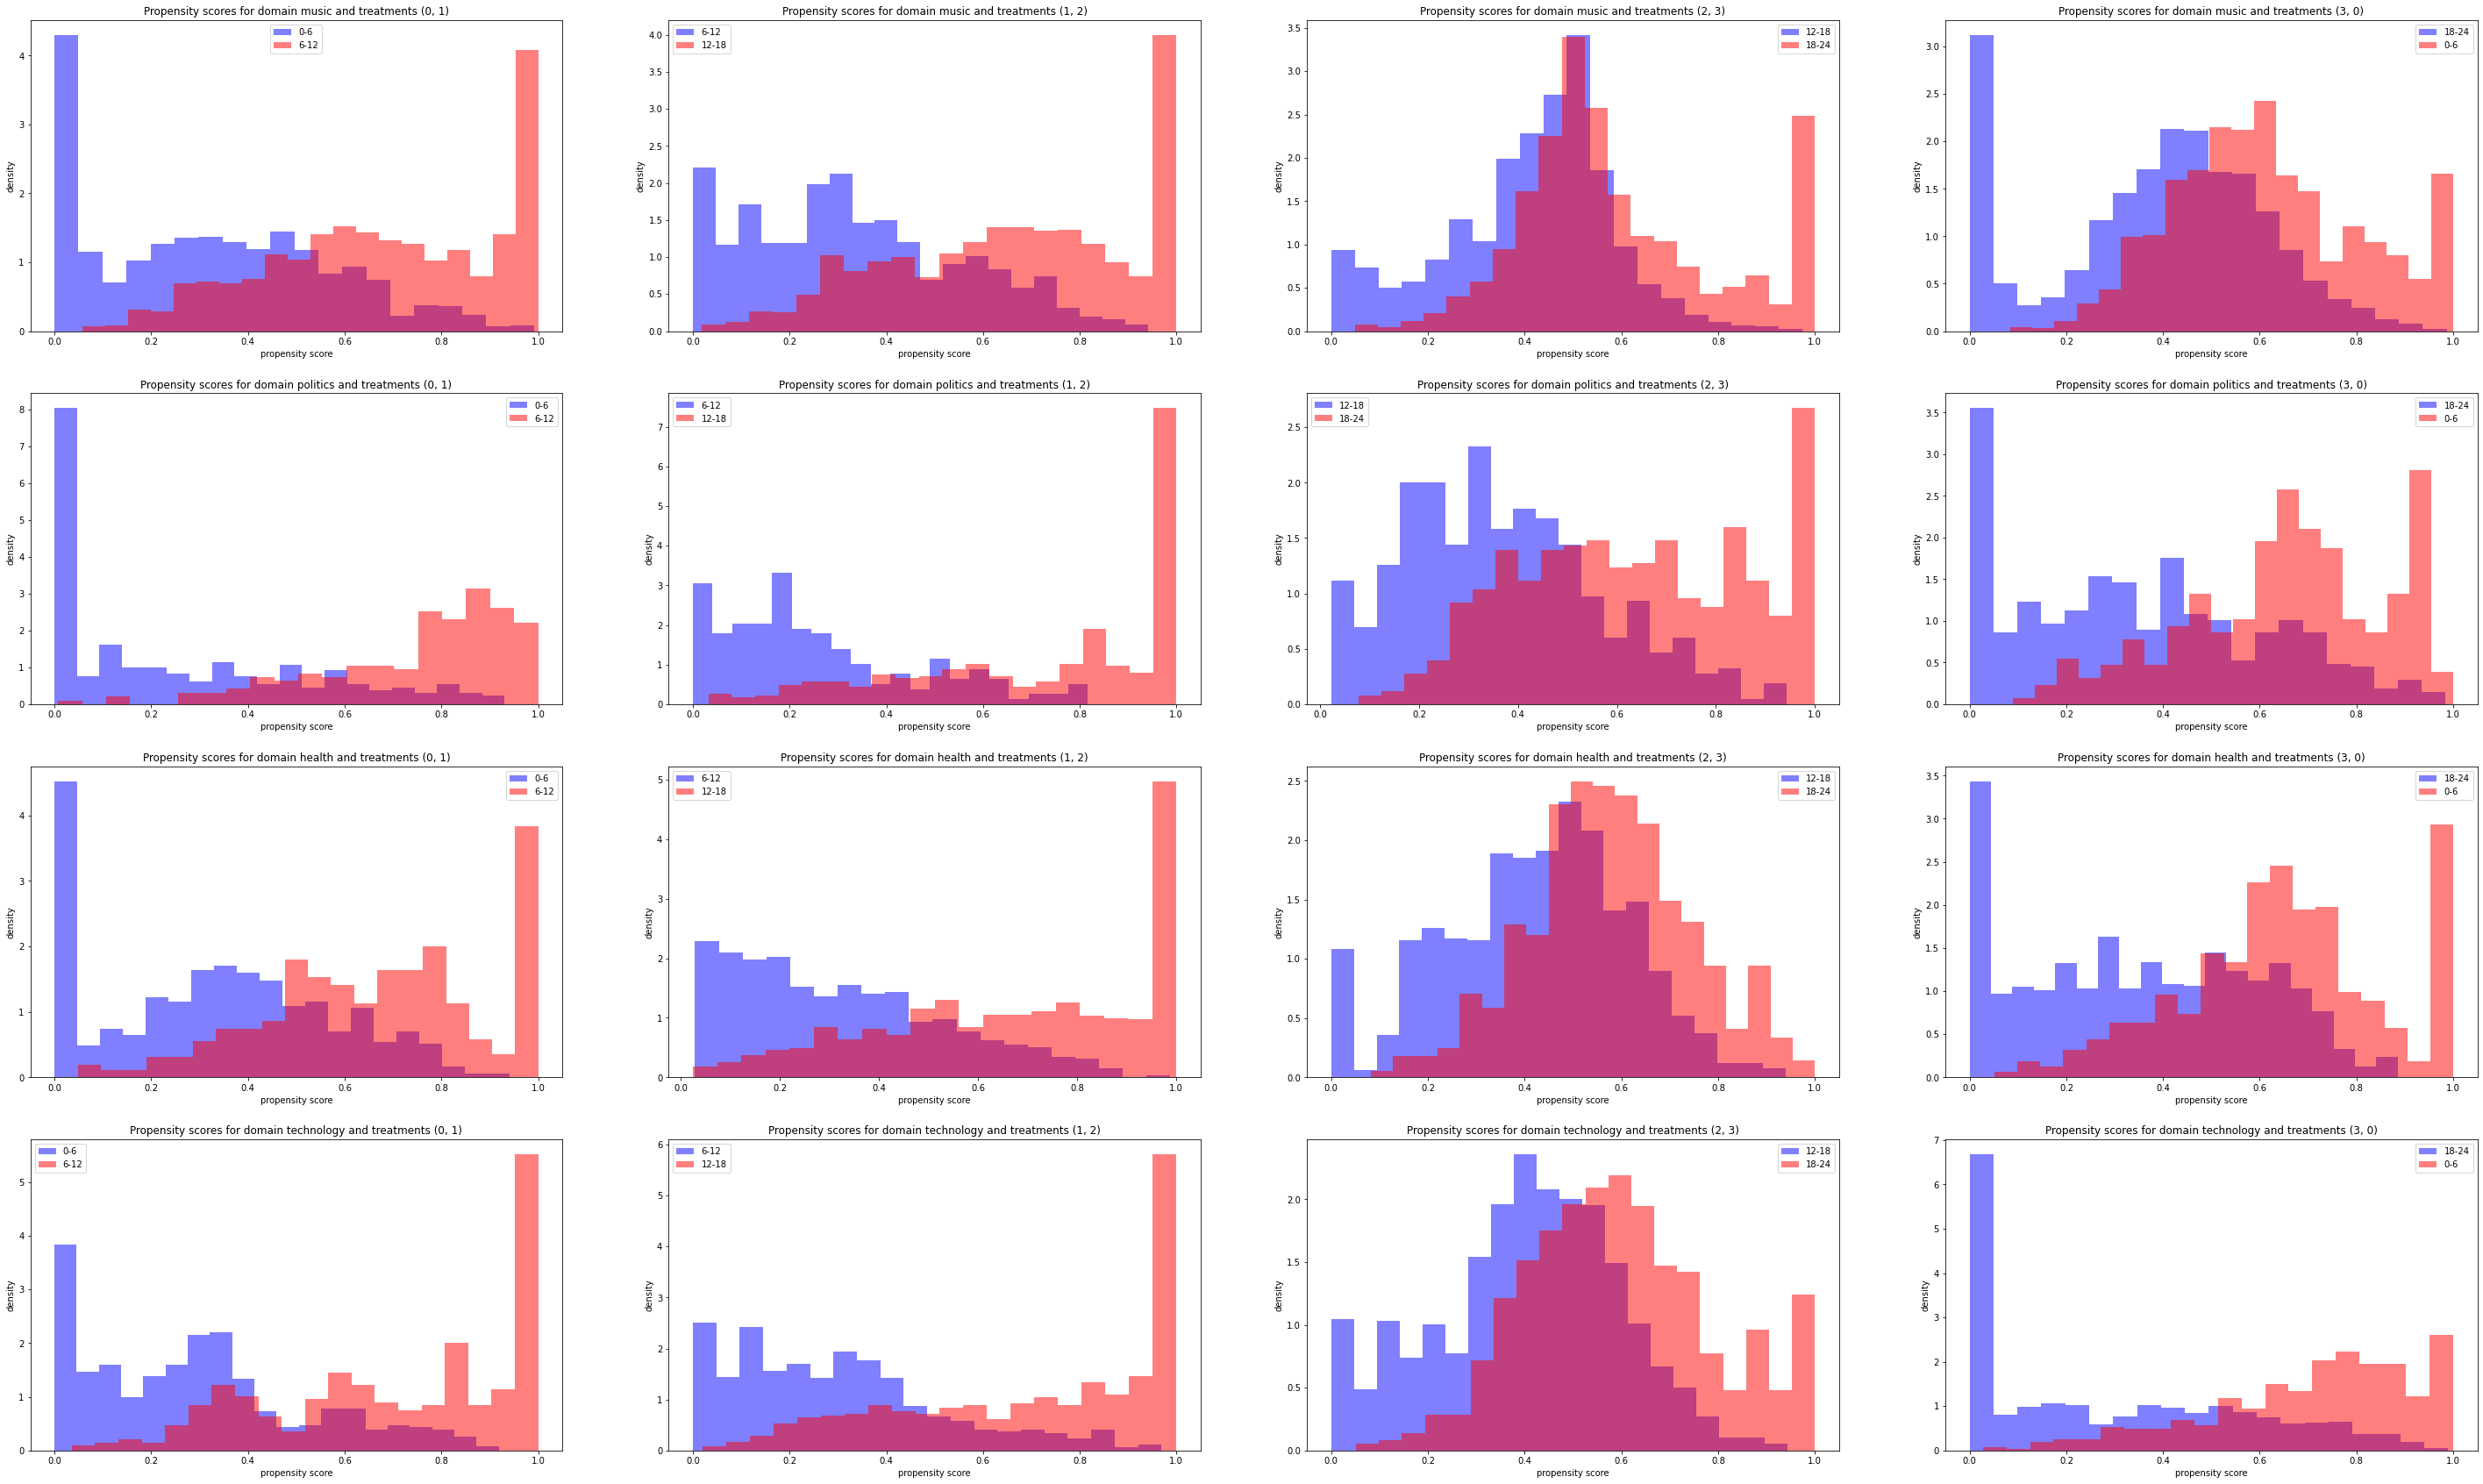

In [7]:
fig, ax = plt.subplots(4,4,figsize=(50,30))
for i, domain in enumerate(domains):
    for j, (t1, t2) in enumerate(treatment_pairs):
        plot_propensity(ax[i, j], T_dict, t1, t2, domain, propensities, title=f'Propensity scores for domain {domain} and treatments {(t1,t2)}')

In [9]:
avg_AUC = list()
for domain in domains:
    for (t1, t2) in treatment_pairs:
        avg_AUC.append(propensities[domain][(t1,t2)][1])
avg_AUC = np.array(avg_AUC).mean()
print(f'average AUC: {round(avg_AUC, 3)}')

average AUC: 0.741
